# Resting State - Classical Features - DBSCAN Clustering

## 0. Imports & Constants

### Libraries

In [1]:
import os
import sys
import joblib
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.impute import SimpleImputer
from sklearn.metrics import silhouette_score, adjusted_rand_score, pairwise_distances
from sklearn.model_selection import RandomizedSearchCV, LeaveOneOut
from sklearn.base import clone

import umap.umap_ as umap
from scipy.stats import f_oneway

In [2]:
root_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(root_dir)

from FeatureExtraction import FeatureExtractor, FEUtilz
from Evaluation import Evaluation, Utilz, LeaveOneOutTrainEval

### Constans

In [3]:
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [4]:
FEATURES_DATA_PATH = rf"..\results\Resting State - best\resting_state_feature_table_22_05_2025_16_25.csv"
CLINICAL_DATA_PATH = rf'C:\Users\97254\Projects Data\ClusteringPD\cluestring_pd_clinical_data.xlsx'

CLINICAL_FEATURE_NAMES = ['Age', 'Disease duration', 
                        'LEDD', 'MoCA', 'UPDRS Total', 'UPDRS part III', 
                        'Gait speed usual', 'Gait speed DT', 
                        'CTT1', 'CTT2']

VGNG_FEATURE_NAMES = ['Vgng_sit_GO_CorrectPercent', 'Vgng_sit_NOGO_CorrectPercent', 'Vgng_walk_GO_CorrectPercent', 
                    'Vgng_walk_NOGO_CorrectPercent', 'Vgng_sit_GO_RT_Mean', 'Vgng_walk_GO_RT_Mean']

MODEL_FEATURE_NAMES = [
    'LZC_mean', 'PermEn_mean', 'fooof_exponent', 
    'beta_relative_bandpower', 'gamma_relative_bandpower', 'alpha_relative_bandpower', 'theta_relative_bandpower'
]

N_SEARCHES = 100
RANDOM_STATE = 42

UMAP_LATENT_DIMENSION = 10
N_NEIGHBORS = 10

MAX_NOISE = 0.2
MIN_SIGNAL = 1 - MAX_NOISE
MIN_CLUSTERS = 2
MAX_CLUSTERS = 4
MIN_CLUSTER_SIZE = 10

### Import Data

In [5]:
feature_table = pd.read_csv(FEATURES_DATA_PATH)
feature_table = feature_table.loc[feature_table['FeatureName'].isin(MODEL_FEATURE_NAMES)]
feature_table['Task'] = feature_table['Condition'].str.split('_').str[0]
feature_table['Condition'] = feature_table['Condition'].str.split('_').str[1]

In [6]:
feature_table['FeatureName'].unique()

array(['LZC_mean', 'PermEn_mean', 'fooof_exponent',
       'theta_relative_bandpower', 'alpha_relative_bandpower',
       'beta_relative_bandpower', 'gamma_relative_bandpower'],
      dtype=object)

In [7]:
data, subjects, raw_feature_names = FEUtilz.get_feature_matrix(feature_table, normalize=True, agg_regions=True)

In [8]:
PD_mask = pd.Series(subjects).str.startswith('PD')

PD_data = data[PD_mask, :]
HC_data = data[~PD_mask, :]

PD_subjects = subjects[PD_mask]

In [9]:
PD_data.shape

(116, 182)

### Setting Epsilon Functions

In [10]:
def build_pipe(preprocessor, dr):
    if dr == None:
        pipe = Pipeline(steps=[
            ('preprocessor', preprocessor)
        ])
    elif dr.lower() == 'pca':
        pipe = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('PCA', PCA(n_components=0.95))
        ])
    elif dr.lower() == 'umap':
        pipe = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('UMAP', umap.UMAP(n_components=UMAP_LATENT_DIMENSION, 
                               n_neighbors=N_NEIGHBORS))
        ])
    else:
        raise(ValueError)
    
    return pipe

In [11]:
def compare_hyperparams(eps_candidates, min_samples_candidates, preprocessor, metric: str, dr: str = None):
    shape = (min_samples_candidates.size, eps_candidates.size)
    n_clusters = np.zeros(shape)
    noise_rates = np.zeros(shape)
    
    n_loo = PD_data.shape[0] - 1
    
    loo = LeaveOneOut()
    pipe = build_pipe(preprocessor, dr)
    for train_idx, i in loo.split(PD_data):
        prepped = pipe.fit_transform(PD_data[train_idx])
        distances = pairwise_distances(prepped, metric=metric, n_jobs=-1)
        np.fill_diagonal(distances, 0.0)
        
        for i, ms in enumerate(min_samples_candidates):
            for j, eps in enumerate(eps_candidates):
                dbscan = DBSCAN(eps=eps, min_samples=ms, metric='precomputed')
                labels = dbscan.fit_predict(distances)
                mask = labels != -1
                n_clusters[i, j] += np.unique(labels[mask]).size
                noise_rates[i, j] += 1 - mask.mean()
    
    return n_clusters / n_loo, noise_rates / n_loo

In [12]:
def plot_n_clusters(eps_candidates, min_samples_candidates, n_clusters):
    N_ms = min_samples_candidates.size
    cmap = plt.get_cmap("Blues")
    
    for i, ms in enumerate(min_samples_candidates):
        sns.lineplot(x=eps_candidates, y=n_clusters[i], color=cmap(i / N_ms))

    plt.ylabel('# Clusters')
    plt.xlabel('$\epsilon$')
    plt.title('Number of Clusters as Function of $\epsilon$')
    plt.show()

In [13]:
def plot_noise_rate(eps_candidates, min_samples_candidates, rates):
    N_ms = min_samples_candidates.size
    cmap = plt.get_cmap("Blues")
    
    for i, ms in enumerate(min_samples_candidates):
        sns.lineplot(x=eps_candidates, y=rates[i], color=cmap(i / N_ms))
    
    plt.ylabel('Noise Rate')
    plt.xlabel('$\epsilon$')
    plt.title('Noise Ratio as Function of $\epsilon$')
    plt.grid()
    plt.show()

In [14]:
def plot_k_distance(data, min_samples_candidates, preprocessor, metric):
    prepped = preprocessor.fit_transform(data)

    for k in min_samples_candidates:
        nn = NearestNeighbors(n_neighbors=k, metric=metric)
        nn.fit(prepped)
        distances, _ = nn.kneighbors(prepped)
        k_distances = np.sort(distances[:, -1])
        plt.plot(k_distances, label=k)
    
    N_ms = len(min_samples_candidates)
    cmap = plt.get_cmap("Blues")
    colors = [cmap(i / max(1, N_ms-1)) for i in range(N_ms)]

    for i, line in enumerate(plt.gca().get_lines()):
        line.set_color(colors[i])
    
    plt.grid()
    plt.ylabel('k-distance')
    plt.title(f'K-Distance Plot [{metric}]')
    plt.show()

### A Vanilla Model

In [15]:
preprocessor = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

In [16]:
vanilla_dbscan = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('DBSCAN', DBSCAN(eps=0.5, min_samples=10, metric='cosine'))
])

In [17]:
evaluator = Evaluation(models=[vanilla_dbscan], names=['Vanilla Model'], cl_data_path=CLINICAL_DATA_PATH, cl_fnames=CLINICAL_FEATURE_NAMES
                    , PD_data=PD_data, PD_subjects=PD_subjects, HC_data=HC_data, cl_VGNG_names=VGNG_FEATURE_NAMES)

======================================== Model Evaluation Report ========================================

--------------------------------------------- General Metrics --------------------------------------------



c:\Users\97254\OneDrive\שולחן העבודה\Projects\ClusteringPD\GMM-Clustering\Evaluation.py:154: RuntimeWarning: Mean of empty slice
  silhouette_means = np.nanmean(silhouette_scores, axis=1)
c:\Users\97254\OneDrive\שולחן העבודה\Projects\ClusteringPD\GMM-Clustering\Evaluation.py:155: RuntimeWarning: Mean of empty slice
  CH_means = np.nanmean(CH_scores, axis=1)
c:\Users\97254\OneDrive\שולחן העבודה\Projects\ClusteringPD\GMM-Clustering\Evaluation.py:156: RuntimeWarning: Mean of empty slice
  DBI_means = np.nanmean(DBI_scores, axis=1)
c:\Users\97254\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


ModelName Vanilla Model     
Statistic          Mean  STD
Metric                      
Validity            0.0  0.0 

-------------------------------------- Low Dimensional Visualization -------------------------------------



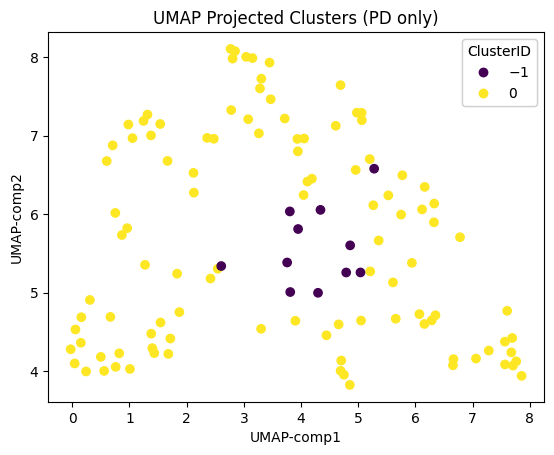

-------------------------------------- Clinical Metrics Differences -------------------------------------



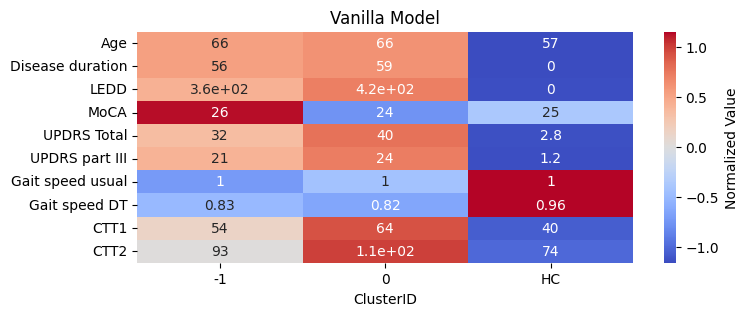

-------------------------------------- VGNG-related Metrics Differences -------------------------------------



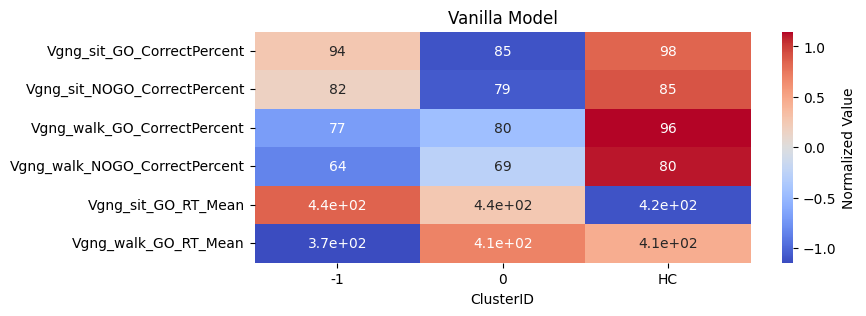

In [18]:
evaluator.report()

## 1. Hyperparameter Tuning

In [19]:
def silhouette_scorer(estimator, X, y=None, metric=None):
    db = estimator.named_steps['DBSCAN']
    Xp = estimator[:-1].transform(X)
    labels = db.labels_
    
    mask = labels != -1
    
    # number of non-noise clusters
    non_noise = labels[mask]
    n_clusters = np.unique(non_noise).size
    if n_clusters < MIN_CLUSTERS or n_clusters > MAX_CLUSTERS:
        return -1.0

    # every cluster must have >= 2 samples for silhouette
    _, counts = np.unique(non_noise, return_counts=True)
    if np.any(counts < MIN_CLUSTER_SIZE):
        return -1.0

    # require enough signal (non-noise fraction)
    if (mask.mean() < MIN_SIGNAL):
        return -1.0
    
    return silhouette_score(Xp[mask], labels[mask], metric=metric)

def euclidean_silhouette(estimator, X, y=None):
    return silhouette_scorer(estimator, X, y, metric='euclidean')

def cosine_silhouette(estimator, X, y=None):
    return silhouette_scorer(estimator, X, y, metric='cosine')

In [20]:
cv = LeaveOneOutTrainEval()

In [21]:
min_samples_candidates = np.arange(5, 21, 1)

### Vanilla-DBSCAN

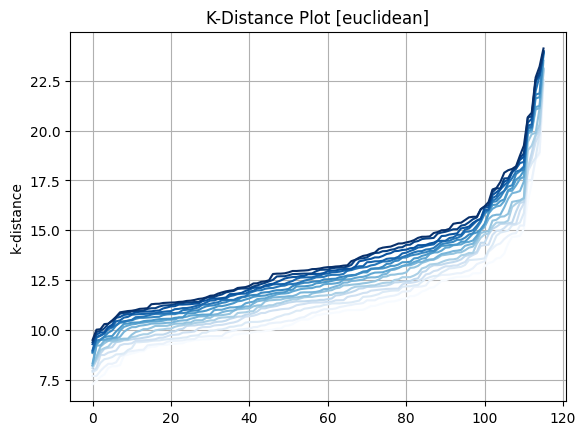

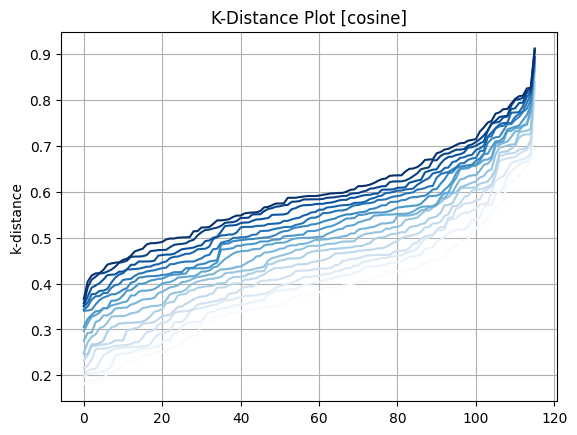

In [22]:
plot_k_distance(PD_data, min_samples_candidates, preprocessor, metric='euclidean')
plot_k_distance(PD_data, min_samples_candidates, preprocessor, metric='cosine')

#### Euclidean Distance

In [23]:
# euc_eps_candidates = np.arange(7.5, 20, 0.1)
# n_clusters, rates = compare_hyperparams(euc_eps_candidates, min_samples_candidates, preprocessor=preprocessor, metric='euclidean')
# plot_n_clusters(euc_eps_candidates, min_samples_candidates, n_clusters)
# plot_noise_rate(euc_eps_candidates, min_samples_candidates, rates)

In [24]:
euc_vanilla_dbscan = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('DBSCAN', DBSCAN(metric='euclidean'))
])

euc_vanilla_params = {
    'DBSCAN__eps': np.arange(10, 16, 0.1),
    'DBSCAN__min_samples': min_samples_candidates
}

euc_vanilla_grid = RandomizedSearchCV(
    euc_vanilla_dbscan,
    euc_vanilla_params,
    scoring=euclidean_silhouette,
    cv=cv,
    n_iter=N_SEARCHES,
    verbose=1
)

In [25]:
euc_vanilla_grid.fit(PD_data)

Fitting 116 folds for each of 100 candidates, totalling 11600 fits


RandomizedSearchCV(cv=LeaveOneOutTrainEval(),
                   estimator=Pipeline(steps=[('preprocessor',
                                              Pipeline(steps=[('imputer',
                                                               SimpleImputer()),
                                                              ('scaler',
                                                               StandardScaler())])),
                                             ('DBSCAN', DBSCAN())]),
                   n_iter=100,
                   param_distributions={'DBSCAN__eps': array([10. , 10.1, 10.2, 10.3, 10.4, 10.5, 10.6, 10.7, 10.8, 10.9, 11. ,
       11.1, 11.2, 11.3, 11.4, 11.5, 11.6, 11.7, 11.8, 11.9, 12. , 12.1,
       12.2, 12.3, 12.4, 12.5, 12.6, 12.7, 12.8, 12.9, 13. , 13.1, 13.2,
       13.3, 13.4, 13.5, 13.6, 13.7, 13.8, 13.9, 14. , 14.1, 14.2, 14.3,
       14.4, 14.5, 14.6, 14.7, 14.8, 14.9, 15. , 15.1, 15.2, 15.3, 15.4,
       15.5, 15.6, 15.7, 15.8, 15.9]),
                                        'DBSCAN__min_samples': array([ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20])},
                   scoring=<function euclidean_silhouette at 0x000001790798CEA0>,
                   verbose=1)

#### Cosine Distance

In [26]:
# cos_eps_candidates = np.arange(0.2, 0.8, 0.01)
# n_clusters, rates = compare_hyperparams(cos_eps_candidates, min_samples_candidates, preprocessor=preprocessor, metric='cosine')
# plot_n_clusters(cos_eps_candidates, min_samples_candidates, n_clusters)
# plot_noise_rate(cos_eps_candidates, min_samples_candidates, rates)

In [27]:
cos_vanilla_dbscan = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('DBSCAN', DBSCAN(metric='cosine'))
])

cos_vanilla_params = {
    'DBSCAN__eps': np.arange(0.2, 0.6, 0.01),
    'DBSCAN__min_samples': min_samples_candidates
}

cos_vanilla_grid = RandomizedSearchCV(
    cos_vanilla_dbscan,
    cos_vanilla_params,
    scoring=cosine_silhouette,
    cv=cv,
    n_iter=N_SEARCHES,
    verbose=1
)

In [28]:
cos_vanilla_grid.fit(PD_data)

Fitting 116 folds for each of 100 candidates, totalling 11600 fits


RandomizedSearchCV(cv=LeaveOneOutTrainEval(),
                   estimator=Pipeline(steps=[('preprocessor',
                                              Pipeline(steps=[('imputer',
                                                               SimpleImputer()),
                                                              ('scaler',
                                                               StandardScaler())])),
                                             ('DBSCAN',
                                              DBSCAN(metric='cosine'))]),
                   n_iter=100,
                   param_distributions={'DBSCAN__eps': array([0.2 , 0.21, 0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 ,
       0.31, 0.32, 0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41,
       0.42, 0.43, 0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52,
       0.53, 0.54, 0.55, 0.56, 0.57, 0.58, 0.59]),
                                        'DBSCAN__min_samples': array([ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20])},
                   scoring=<function cosine_silhouette at 0x0000017909A9D6C0>,
                   verbose=1)

### PCA-DBSCAN

In [29]:
PCA_preprocessor = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('PCA', PCA(n_components=0.95)),
])

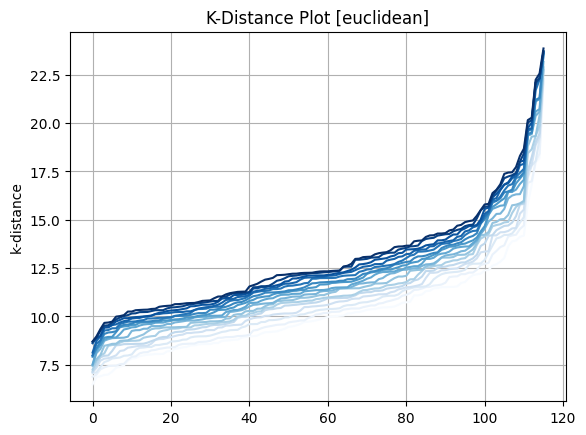

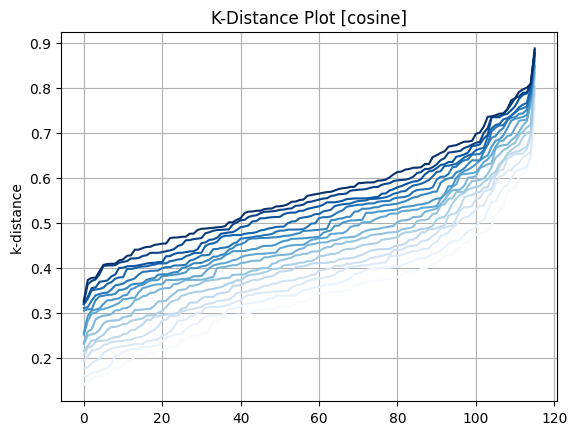

In [30]:
plot_k_distance(PD_data, min_samples_candidates, PCA_preprocessor, metric='euclidean')
plot_k_distance(PD_data, min_samples_candidates, PCA_preprocessor, metric='cosine')

#### Euclidean Distance

In [31]:
# n_clusters, rates = compare_hyperparams(euc_eps_candidates, min_samples_candidates, preprocessor=preprocessor, dr='pca', metric='euclidean')
# plot_n_clusters(euc_eps_candidates, min_samples_candidates, n_clusters)
# plot_noise_rate(euc_eps_candidates, min_samples_candidates, rates)

In [32]:
euc_PCA_dbscan = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('PCA', PCA()),
    ('DBSCAN', DBSCAN(metric='euclidean'))
])

euc_PCA_dbscan_params = {
    'DBSCAN__eps': np.arange(11, 20, 0.1),
    'DBSCAN__min_samples': min_samples_candidates,
    'PCA__n_components': [0.8, 0.85, 0.9, 0.95]
}

euc_PCA_dbscan_grid = RandomizedSearchCV(
    euc_PCA_dbscan,
    euc_PCA_dbscan_params,
    scoring=euclidean_silhouette,
    error_score='raise',
    cv=cv,
    n_iter=N_SEARCHES,
    verbose=1
)

In [33]:
euc_PCA_dbscan_grid.fit(PD_data)

Fitting 116 folds for each of 100 candidates, totalling 11600 fits


KeyboardInterrupt: 

In [ ]:
euc_PCA_dbscan_grid.best_estimator_.named_steps['PCA'].n_components_

np.int64(26)

======================================== Model Evaluation Report ========================================

--------------------------------------------- General Metrics --------------------------------------------



c:\Users\97254\OneDrive\שולחן העבודה\Projects\ClusteringPD\GMM-Clustering\Evaluation.py:154: RuntimeWarning: Mean of empty slice
  silhouette_means = np.nanmean(silhouette_scores, axis=1)
c:\Users\97254\OneDrive\שולחן העבודה\Projects\ClusteringPD\GMM-Clustering\Evaluation.py:155: RuntimeWarning: Mean of empty slice
  CH_means = np.nanmean(CH_scores, axis=1)
c:\Users\97254\OneDrive\שולחן העבודה\Projects\ClusteringPD\GMM-Clustering\Evaluation.py:156: RuntimeWarning: Mean of empty slice
  DBI_means = np.nanmean(DBI_scores, axis=1)
c:\Users\97254\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


ModelName Euclidean PCA      Euclidean Vanilla     
Statistic          Mean  STD              Mean  STD
Metric                                             
Validity            0.0  0.0               0.0  0.0 

-------------------------------------- Low Dimensional Visualization -------------------------------------



<Figure size 640x480 with 0 Axes>

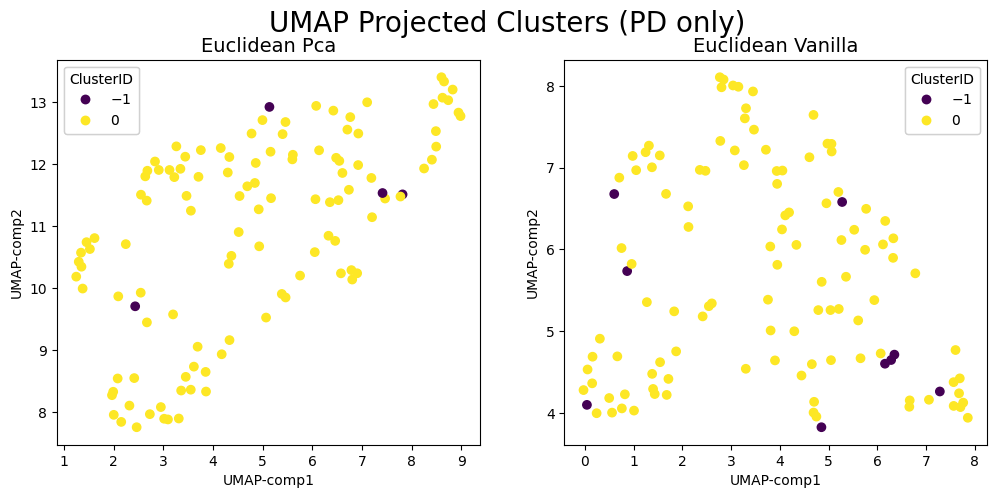

In [ ]:
evaluator.set_models(models=[euc_PCA_dbscan_grid.best_estimator_, euc_vanilla_grid.best_estimator_], names=['Euclidean PCA', 'Euclidean Vanilla'])
evaluator.report(include_clinical=False)

#### Cosine Distance

In [ ]:
# n_clusters, rates = compare_hyperparams(cos_eps_candidates, min_samples_candidates, preprocessor=preprocessor, dr='pca', metric='cosine')
# plot_n_clusters(cos_eps_candidates, min_samples_candidates, n_clusters)
# plot_noise_rate(cos_eps_candidates, min_samples_candidates, rates)

In [ ]:
cos_PCA_dbscan = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('PCA', PCA()),
    ('DBSCAN', DBSCAN(metric='cosine'))
])

cos_PCA_dbscan_params = {
    'DBSCAN__eps': np.arange(0.3, 0.6, 0.01),
    'DBSCAN__min_samples': min_samples_candidates,
    'PCA__n_components': [0.8, 0.85, 0.9, 0.95]
}

cos_PCA_dbscan_grid = RandomizedSearchCV(
    cos_PCA_dbscan,
    cos_PCA_dbscan_params,
    scoring=cosine_silhouette,
    error_score='raise',
    cv=cv,
    n_iter=N_SEARCHES,
    verbose=1
)

In [102]:
cos_PCA_dbscan_grid.fit(PD_data)

NameError: name 'cos_PCA_dbscan_grid' is not defined

In [ ]:
cos_PCA_dbscan_grid.best_estimator_.named_steps['PCA'].n_components_

np.int64(8)

In [ ]:
evaluator.set_models(models=[cos_PCA_dbscan_grid.best_estimator_, cos_vanilla_grid.best_estimator_], names=['Cosine PCA', 'Cosine Vanilla'])
evaluator.report(include_clinical=False)

======================================== Model Evaluation Report ========================================

--------------------------------------------- General Metrics --------------------------------------------



KeyboardInterrupt: 

### UMAP-DBSCAN

In [34]:
UMAP_preprocessor = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('UMAP', umap.UMAP(n_components=UMAP_LATENT_DIMENSION, 
                    n_neighbors=N_NEIGHBORS, 
                    random_state=RANDOM_STATE))
])

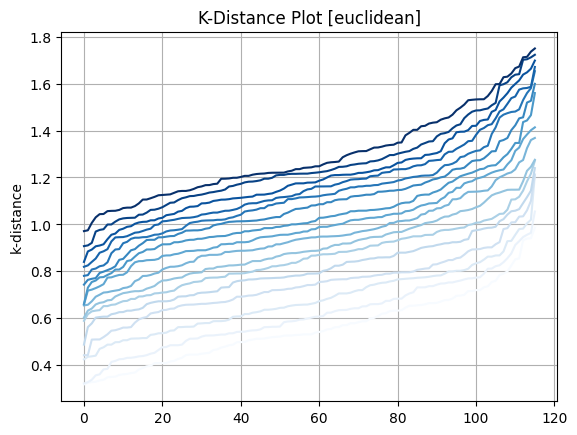

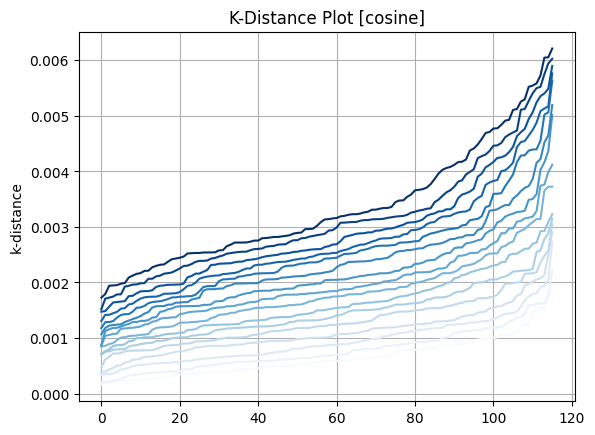

In [35]:
plot_k_distance(PD_data, min_samples_candidates, UMAP_preprocessor, metric='euclidean')
plot_k_distance(PD_data, min_samples_candidates, UMAP_preprocessor, metric='cosine')

#### Euclidean Distance

In [36]:
# euc_UMAP_eps_candidates = np.arange(0.4, 1.8, 0.01)
# n_clusters, rates = compare_hyperparams(euc_UMAP_eps_candidates, min_samples_candidates, preprocessor=preprocessor, dr='umap', metric='euclidean')
# plot_n_clusters(euc_UMAP_eps_candidates, min_samples_candidates, n_clusters)
# plot_noise_rate(euc_UMAP_eps_candidates, min_samples_candidates, rates)

In [37]:
euc_UMAP_dbscan = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('UMAP', umap.UMAP(random_state=RANDOM_STATE)),
    ('DBSCAN', DBSCAN(metric='euclidean'))
])

euc_UMAP_params = {
    'DBSCAN__eps': np.arange(0.4, 1.2, 0.01),
    'DBSCAN__min_samples': min_samples_candidates,
    'UMAP__n_components': np.arange(2, 22, 2),
    'UMAP__n_neighbors': np.arange(2, 22, 2)
}

euc_UMAP_grid = RandomizedSearchCV(
    euc_UMAP_dbscan,
    euc_UMAP_params,
    scoring=euclidean_silhouette,
    error_score='raise',
    cv=cv,
    n_iter=N_SEARCHES,
    verbose=1
)

In [38]:
euc_UMAP_grid.fit(PD_data)

Fitting 116 folds for each of 100 candidates, totalling 11600 fits


RandomizedSearchCV(cv=LeaveOneOutTrainEval(), error_score='raise',
                   estimator=Pipeline(steps=[('preprocessor',
                                              Pipeline(steps=[('imputer',
                                                               SimpleImputer()),
                                                              ('scaler',
                                                               StandardScaler())])),
                                             ('UMAP', UMAP(random_state=42)),
                                             ('DBSCAN', DBSCAN())]),
                   n_iter=100,
                   param_distributions={'DBSCAN__eps': array([0.4 , 0.41, 0.42, 0.43, 0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 ,
       0.51, 0.52...
       0.95, 0.96, 0.97, 0.98, 0.99, 1.  , 1.01, 1.02, 1.03, 1.04, 1.05,
       1.06, 1.07, 1.08, 1.09, 1.1 , 1.11, 1.12, 1.13, 1.14, 1.15, 1.16,
       1.17, 1.18, 1.19]),
                                        'DBSCAN__min_samples': array([ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]),
                                        'UMAP__n_components': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18, 20]),
                                        'UMAP__n_neighbors': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18, 20])},
                   scoring=<function euclidean_silhouette at 0x000001790798CEA0>,
                   verbose=1)

======================================== Model Evaluation Report ========================================

--------------------------------------------- General Metrics --------------------------------------------



c:\Users\97254\OneDrive\שולחן העבודה\Projects\ClusteringPD\GMM-Clustering\Evaluation.py:154: RuntimeWarning: Mean of empty slice
  silhouette_means = np.nanmean(silhouette_scores, axis=1)
c:\Users\97254\OneDrive\שולחן העבודה\Projects\ClusteringPD\GMM-Clustering\Evaluation.py:155: RuntimeWarning: Mean of empty slice
  CH_means = np.nanmean(CH_scores, axis=1)
c:\Users\97254\OneDrive\שולחן העבודה\Projects\ClusteringPD\GMM-Clustering\Evaluation.py:156: RuntimeWarning: Mean of empty slice
  DBI_means = np.nanmean(DBI_scores, axis=1)
c:\Users\97254\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


ModelName        Euclidean UMAP            Euclidean Vanilla     
Statistic                  Mean        STD              Mean  STD
Metric                                                           
CH_score              82.957685  10.355907               NaN  NaN
DBI_score              0.878481   0.048064               NaN  NaN
Validity               0.948276   0.221470               0.0  0.0
silhouette_score       0.407235   0.026567               NaN  NaN 

-------------------------------------- Low Dimensional Visualization -------------------------------------



<Figure size 640x480 with 0 Axes>

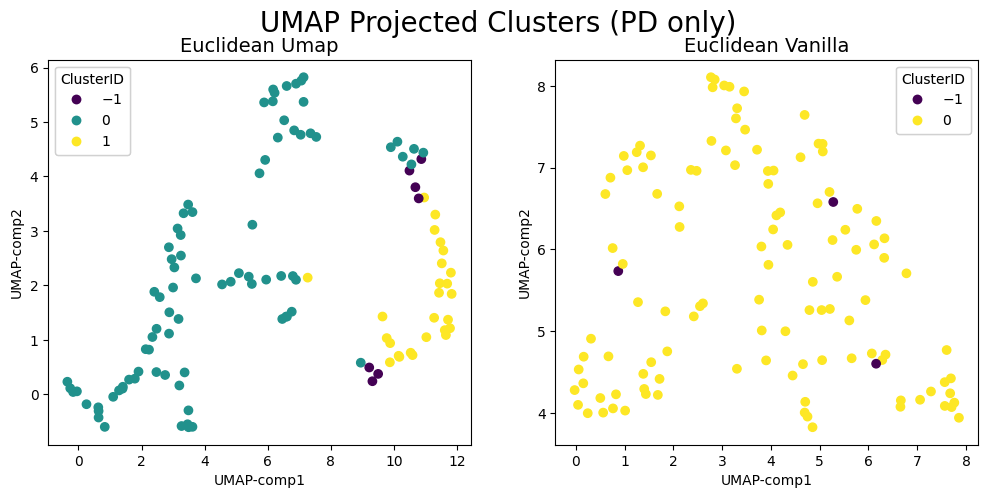

In [39]:
evaluator.set_models(models=[euc_UMAP_grid.best_estimator_, euc_vanilla_grid.best_estimator_], names=['Euclidean UMAP', 'Euclidean Vanilla'])
evaluator.report(include_clinical=False)

#### Cosine Distance

In [40]:
# cos_UMAP_eps_candidates = np.arange(0.0005, 0.02, 0.0005)
# n_clusters, rates = compare_hyperparams(cos_UMAP_eps_candidates, min_samples_candidates, preprocessor=preprocessor, dr='umap', metric='cosine')
# plot_n_clusters(cos_UMAP_eps_candidates, min_samples_candidates, n_clusters)
# plot_noise_rate(cos_UMAP_eps_candidates, min_samples_candidates, rates)

In [41]:
cos_UMAP_dbscan = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('UMAP', umap.UMAP(random_state=RANDOM_STATE)),
    ('DBSCAN', DBSCAN(metric='cosine'))
])

cos_UMAP_params = {
    'DBSCAN__eps': np.arange(0.001, 0.005, 0.0005),
    'DBSCAN__min_samples': min_samples_candidates,
    'UMAP__n_components': np.arange(2, 22, 2),
    'UMAP__n_neighbors': np.arange(2, 22, 2)
}

cos_UMAP_grid = RandomizedSearchCV(
    cos_UMAP_dbscan,
    cos_UMAP_params,
    scoring=cosine_silhouette,
    error_score='raise',
    cv=cv,
    n_iter=N_SEARCHES,
    verbose=1
)

In [42]:
cos_UMAP_grid.fit(PD_data)

Fitting 116 folds for each of 100 candidates, totalling 11600 fits


RandomizedSearchCV(cv=LeaveOneOutTrainEval(), error_score='raise',
                   estimator=Pipeline(steps=[('preprocessor',
                                              Pipeline(steps=[('imputer',
                                                               SimpleImputer()),
                                                              ('scaler',
                                                               StandardScaler())])),
                                             ('UMAP', UMAP(random_state=42)),
                                             ('DBSCAN',
                                              DBSCAN(metric='cosine'))]),
                   n_iter=100,
                   param_distributions={'DBSCAN__eps': array([0.001 , 0.0015, 0.002 , 0.0025, 0.003 , 0.0035, 0.004 , 0.0045]),
                                        'DBSCAN__min_samples': array([ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]),
                                        'UMAP__n_components': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18, 20]),
                                        'UMAP__n_neighbors': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18, 20])},
                   scoring=<function cosine_silhouette at 0x0000017909A9D6C0>,
                   verbose=1)

======================================== Model Evaluation Report ========================================

--------------------------------------------- General Metrics --------------------------------------------

ModelName        Cosine UMAP            Cosine Vanilla          
Statistic               Mean        STD           Mean       STD
Metric                                                          
CH_score          122.716353  38.615182      41.606098  0.547448
DBI_score           0.704665   0.100879       1.455808  0.013477
Validity            0.810345   0.392028       1.000000  0.000000
silhouette_score    0.492103   0.068211       0.252610  0.003405 

-------------------------------------- Low Dimensional Visualization -------------------------------------



<Figure size 640x480 with 0 Axes>

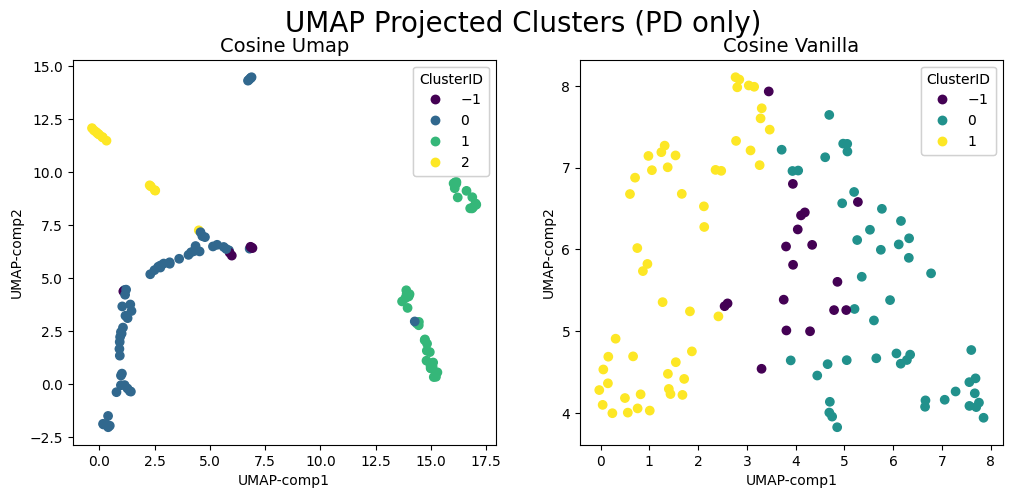

In [43]:
evaluator.set_models(models=[cos_UMAP_grid.best_estimator_, cos_vanilla_grid.best_estimator_], names=['Cosine UMAP', 'Cosine Vanilla'])
evaluator.report(include_clinical=False)

### Stability

In [44]:
def calc_stability(estimator, data: np.ndarray, name: str, validation_trials: int = 100):
    clusters = [estimator.fit_predict(data) for _ in range(validation_trials)]

    ARIs = [
        adjusted_rand_score(clusters[i], clusters[j])
        for i in range(validation_trials)
        for j in range(i+1, validation_trials)
    ]

    mean_ARI = np.mean(ARIs)
    std_ARI = np.std(ARIs)
    print(f"Adjusted Rand Index for {name} is {round(mean_ARI, 2)} ({round(std_ARI, 2)}) [mean (std)].")

#### Vanilla

In [45]:
calc_stability(euc_vanilla_grid.best_estimator_, PD_data, name='Vanilla-Euclidean-DBSCAN')

Adjusted Rand Index for Vanilla-Euclidean-DBSCAN is 1.0 (0.0) [mean (std)].


In [46]:
calc_stability(cos_vanilla_grid.best_estimator_, PD_data, name='Vanilla-Cosine-DBSCAN')

Adjusted Rand Index for Vanilla-Cosine-DBSCAN is 1.0 (0.0) [mean (std)].


#### PCA

In [47]:
calc_stability(euc_PCA_dbscan_grid.best_estimator_, PD_data, name='PCA-Euclidean-DBSCAN')

AttributeError: 'RandomizedSearchCV' object has no attribute 'best_estimator_'

In [ ]:
calc_stability(cos_PCA_dbscan_grid.best_estimator_, PD_data, name='PCA-Cosine-DBSCAN')

Adjusted Rand Index for PCA-Cosine-DBSCAN is 1.0 (0.0) [mean (std)].


#### UMAP

In [48]:
euc_UMAP_grid.best_estimator_['UMAP'].random_state = None
calc_stability(euc_UMAP_grid.best_estimator_, PD_data, name='UMAP-Euclidean-DBSCAN')

Adjusted Rand Index for UMAP-Euclidean-DBSCAN is 0.74 (0.27) [mean (std)].


In [49]:
cos_UMAP_grid.best_estimator_['UMAP'].random_state = None
calc_stability(cos_UMAP_grid.best_estimator_, PD_data, name='UMAP-Cosine-DBSCAN')

Adjusted Rand Index for UMAP-Cosine-DBSCAN is 0.57 (0.26) [mean (std)].


## 2. Best Model Training & Evaluation

### General Evaluation

======================================== Model Evaluation Report ========================================

--------------------------------------------- General Metrics --------------------------------------------

ModelName        Euclidean UMAP           
Statistic                  Mean        STD
Metric                                    
CH_score              82.957685  10.355907
DBI_score              0.878481   0.048064
Validity               0.948276   0.221470
silhouette_score       0.407235   0.026567 

-------------------------------------- Low Dimensional Visualization -------------------------------------



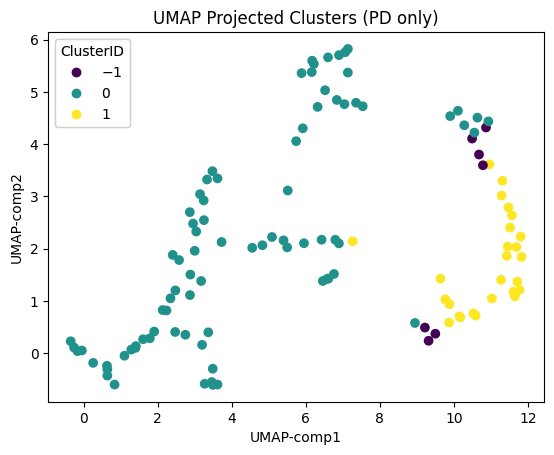

-------------------------------------- Clinical Metrics Differences -------------------------------------



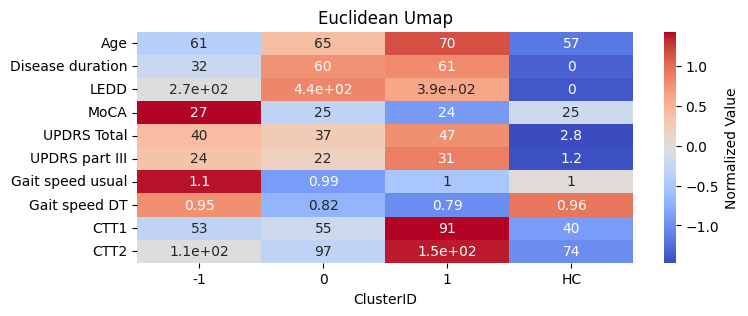

-------------------------------------- VGNG-related Metrics Differences -------------------------------------



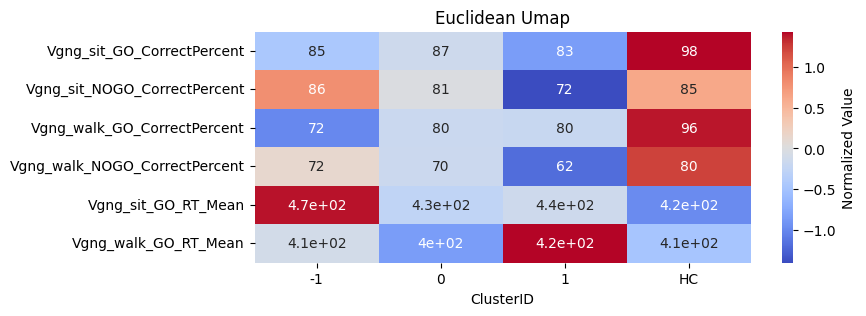

In [50]:
best_model = euc_UMAP_grid.best_estimator_
best_model['UMAP'].random_state = RANDOM_STATE

joblib.dump(best_model, "UMAP_DBSCAN.pkl")

evaluator.set_models(models=[best_model], names=['Euclidean UMAP'])
evaluator.report()

In [51]:
clusters = pd.DataFrame({
    'clusterID': best_model.fit_predict(PD_data),
    'Subject': PD_subjects
}).set_index('Subject')
cl_data = pd.merge(evaluator.cl_data, clusters, left_on='Subject', right_index=True)
cl_data['Age of Onset'] = cl_data['Age'] - cl_data['Disease duration'] / 12

In [52]:
clusters['clusterID'].value_counts()

clusterID
 0    83
 1    26
-1     7
Name: count, dtype: int64

In [53]:
clusters.to_csv('DBSCAN_clusters.csv')

### Categorical Distributions

In [54]:
cl_data.groupby(['clusterID', 'Group'])['Subject'].nunique() / cl_data.groupby(['clusterID'])['Subject'].nunique()

clusterID  Group     
-1         GBA           0.428571
           Idiopathic    0.285714
           LRRK2         0.285714
 0         GBA           0.156627
           Idiopathic    0.590361
           LRRK2         0.253012
 1         GBA           0.153846
           Idiopathic    0.807692
           LRRK2, GBA    0.038462
Name: Subject, dtype: float64

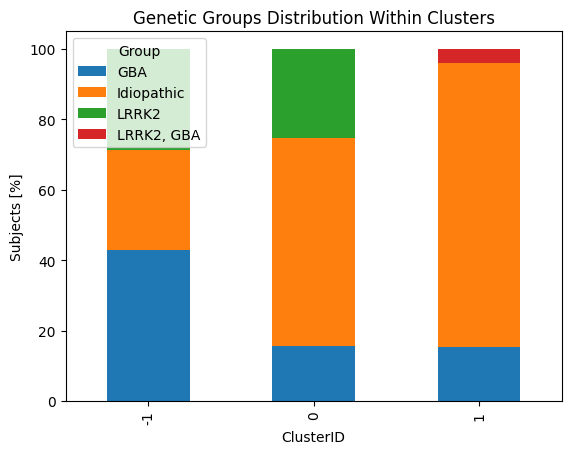

In [55]:
evaluator.visualize_categorical_distribution(best_model, PD_data, PD_subjects, feature_name='Group'
                                           , title = 'Genetic Groups Distribution Within Clusters')

In [56]:
cl_data.groupby(['clusterID', 'Patient Type'])['Subject'].nunique() / cl_data.groupby(['clusterID'])['Subject'].nunique()

clusterID  Patient Type
-1         PIGD            0.428571
           TD              0.571429
 0         Intermediate    0.084337
           PIGD            0.313253
           TD              0.421687
 1         Intermediate    0.230769
           PIGD            0.346154
           TD              0.153846
Name: Subject, dtype: float64

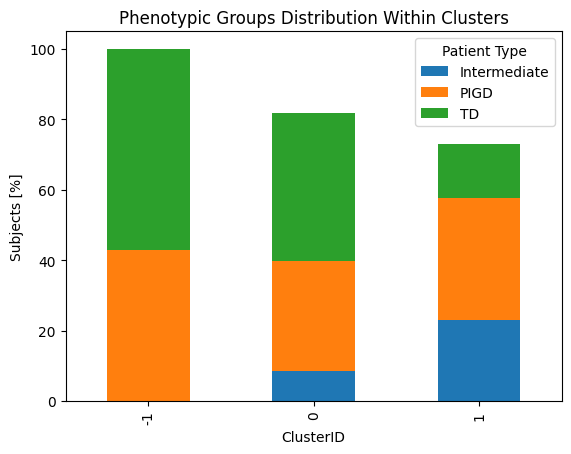

In [57]:
evaluator.visualize_categorical_distribution(best_model, PD_data, PD_subjects, feature_name='Patient Type'
                                           , title = 'Phenotypic Groups Distribution Within Clusters')

In [58]:
cl_data.groupby(['clusterID', 'Affected side'])['Subject'].nunique() / cl_data.groupby(['clusterID'])['Subject'].nunique()

clusterID  Affected side
-1         Left             0.428571
           Right            0.571429
 0         Equal            0.024096
           Left             0.469880
           Right            0.445783
 1         Left             0.461538
           Right            0.346154
Name: Subject, dtype: float64

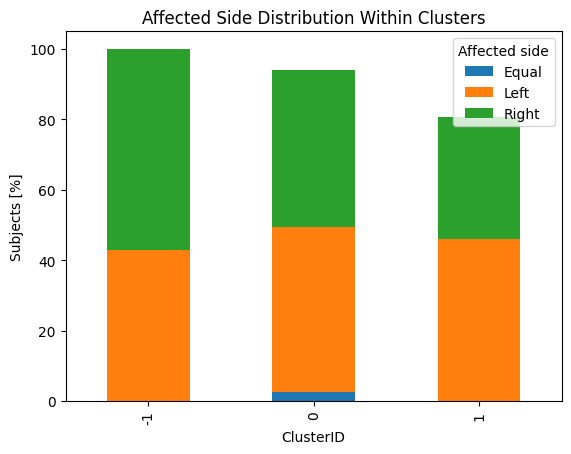

In [59]:
evaluator.visualize_categorical_distribution(best_model, PD_data, PD_subjects, feature_name='Affected side'
                                           , title = 'Affected Side Distribution Within Clusters')

In [60]:
cl_data.groupby(['clusterID', 'Gender'])['Subject'].nunique() / cl_data.groupby(['clusterID'])['Subject'].nunique()

clusterID  Gender
-1         Female    0.142857
           Male      0.857143
 0         Female    0.397590
           Male      0.602410
 1         Female    0.384615
           Male      0.615385
Name: Subject, dtype: float64

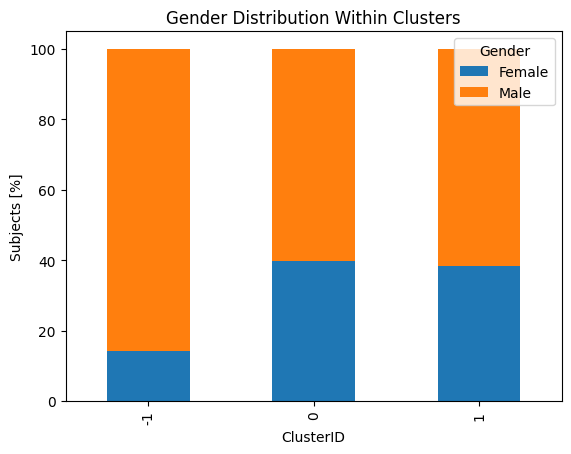

In [61]:
evaluator.visualize_categorical_distribution(best_model, PD_data, PD_subjects, feature_name='Gender'
                                           , title = 'Gender Distribution Within Clusters')

### Topological Distributions

In [62]:
feature_table['FeatureName'].unique()

array(['LZC_mean', 'PermEn_mean', 'fooof_exponent',
       'theta_relative_bandpower', 'alpha_relative_bandpower',
       'beta_relative_bandpower', 'gamma_relative_bandpower'],
      dtype=object)

In [63]:
features = feature_table.pivot_table(
    index=['Subject', 'Condition', 'Electrode'],
    columns='FeatureName',
    values='RawValue'
).reset_index()

clustered_features = pd.merge(features, clusters, on='Subject', how='left')
clustered_features.loc[clustered_features['Subject'].str.startswith('HC'), 'clusterID'] = 'HC'

In [64]:
from Topomap import TopoPlot
HEIGHT = 4
WIDTH = 3

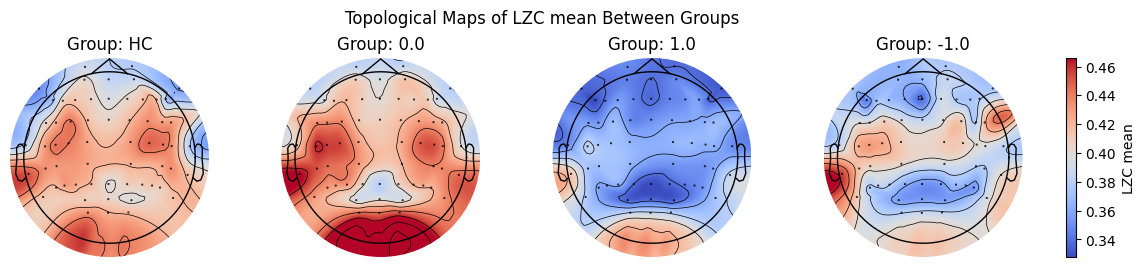

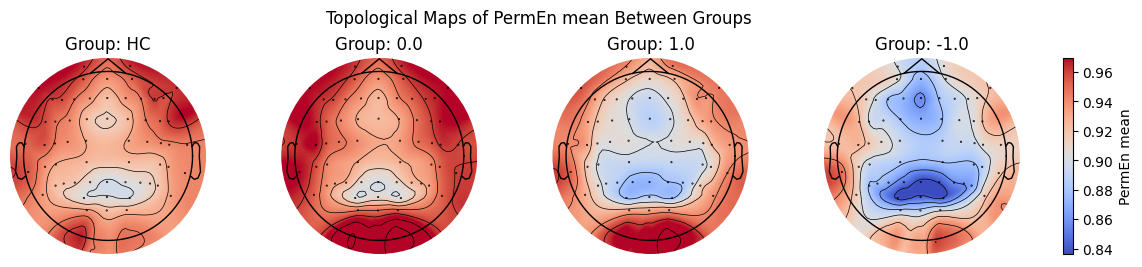

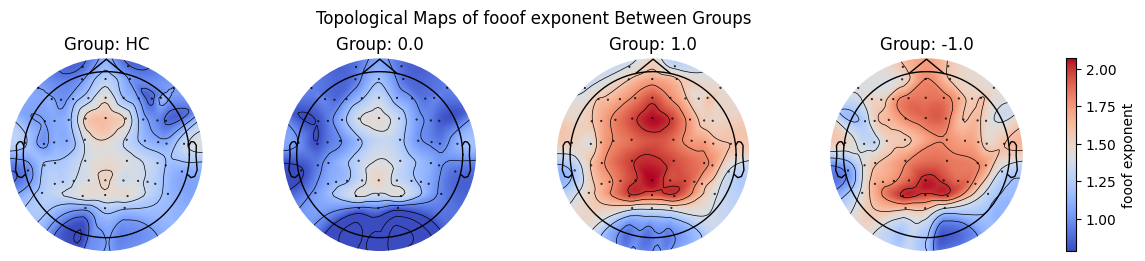

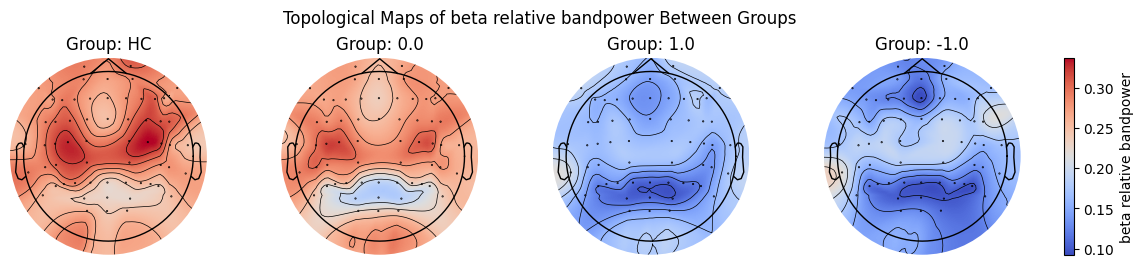

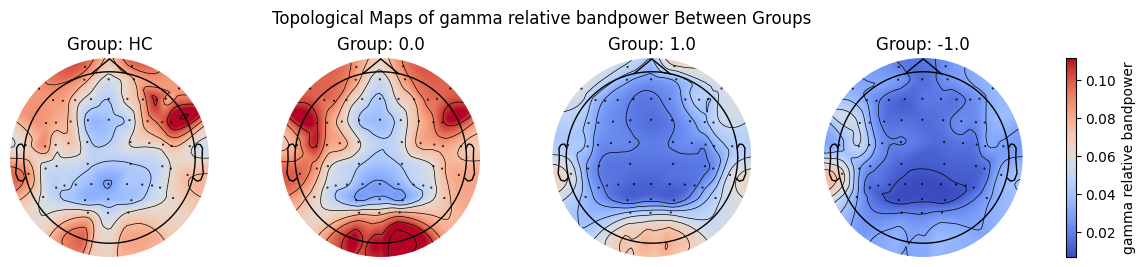

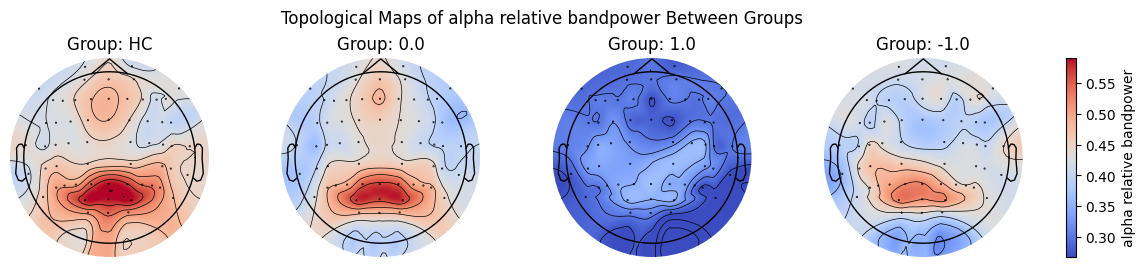

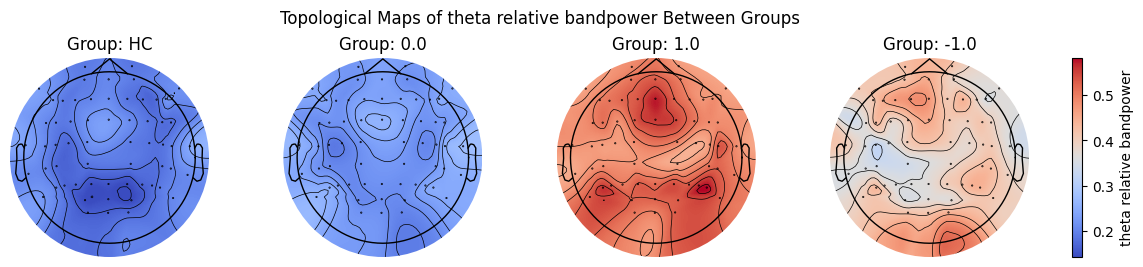

In [65]:
sit_plot = TopoPlot(
    data=clustered_features.loc[clustered_features['Condition'] == 'sit'], 
    group_col='clusterID', 
    channel_col='Electrode', 
    feature_names=MODEL_FEATURE_NAMES,
    dims=(WIDTH, HEIGHT),
    cmap='coolwarm')

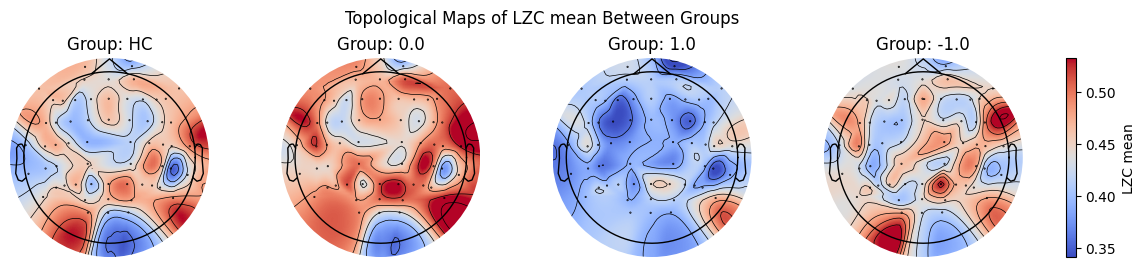

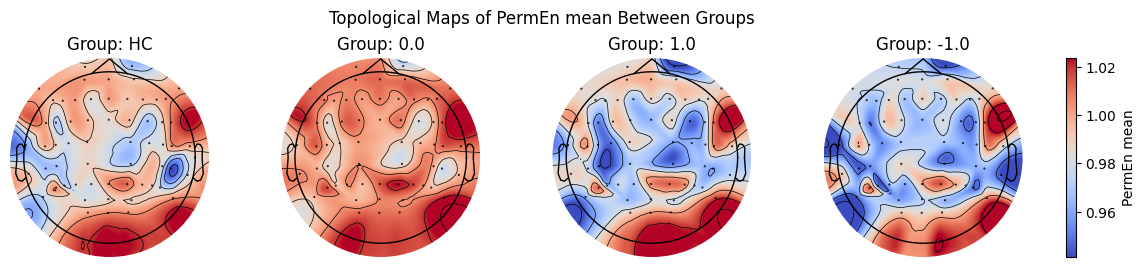

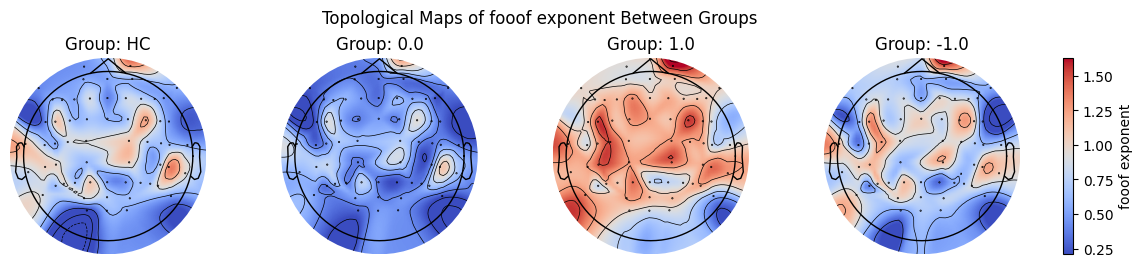

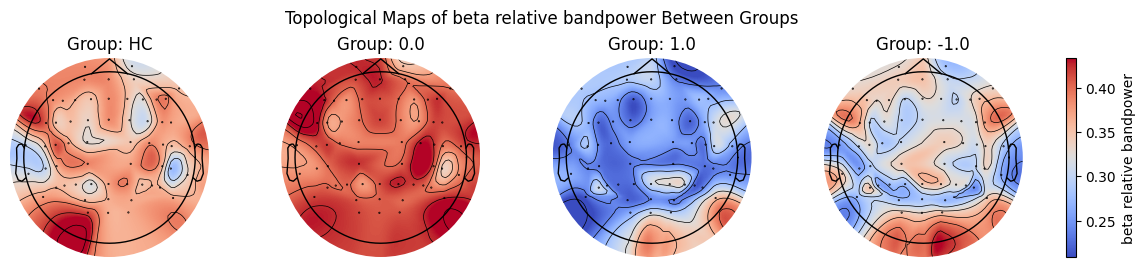

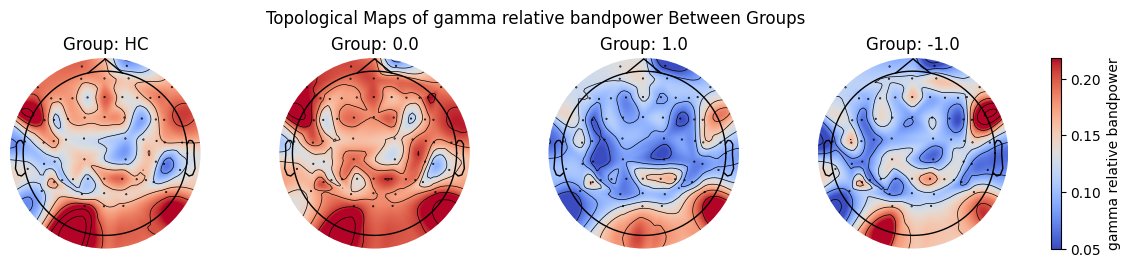

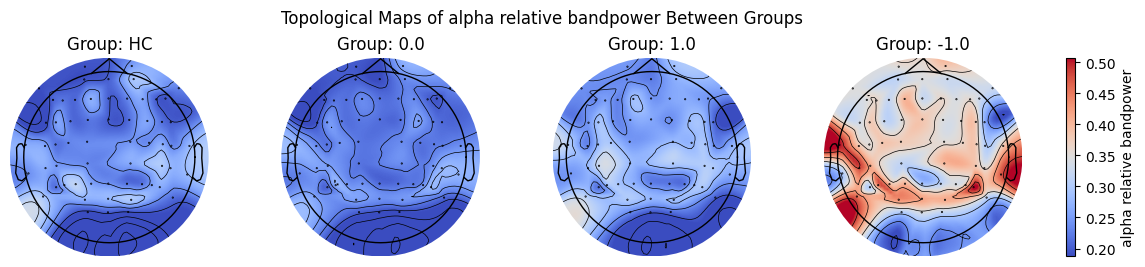

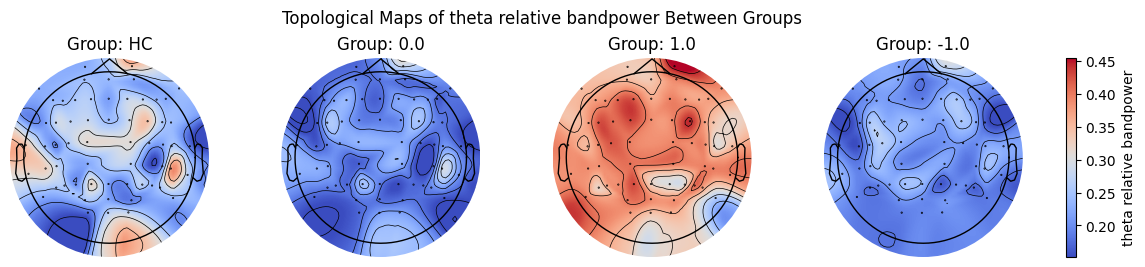

In [66]:
walk_plot = TopoPlot(
    data=clustered_features.loc[clustered_features['Condition'] == 'walk'], 
    group_col='clusterID', 
    channel_col='Electrode', 
    feature_names=MODEL_FEATURE_NAMES,
    dims=(WIDTH, HEIGHT),
    cmap='coolwarm')

### Numerical Distributions

In [67]:
def plot_hist(data, feature_name, bins):
    
    for c in range(3):
        c_data = data.loc[data['clusterID'] == c - 1]
        mean = round(c_data[feature_name].mean(), 2)
        std = round(c_data[feature_name].std(), 2)
        print(f"C{c-1}: Mean {feature_name} = {mean} [{std}]")
        sns.histplot(c_data, x=feature_name, stat='probability', label=c-1, alpha=.6, bins=bins)

    plt.legend()
    plt.title(f"{feature_name} Distribution between Clusters")
    plt.show()

In [68]:
def anova(data, feature_name):
    c0 = data.loc[data['clusterID'] == 0, feature_name].dropna()
    c1 = data.loc[data['clusterID'] == 1, feature_name].dropna()

    F, p = f_oneway(c0, c1)
    print(f"F = {F:.3f}, p = {p:.4f}")

C-1: Mean Age = 61.0 [13.56]
C0: Mean Age = 65.48 [9.41]
C1: Mean Age = 69.58 [7.08]


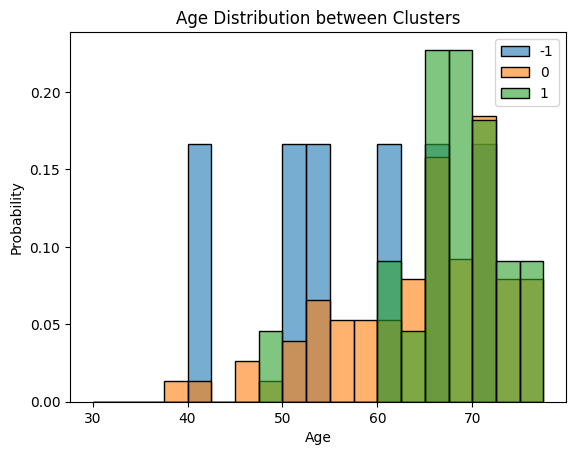

In [69]:
plot_hist(cl_data, feature_name='Age', bins=np.arange(30, 80, 2.5))

C-1: Mean Age of Onset = 58.35 [13.52]
C0: Mean Age of Onset = 60.47 [9.3]
C1: Mean Age of Onset = 64.47 [7.08]


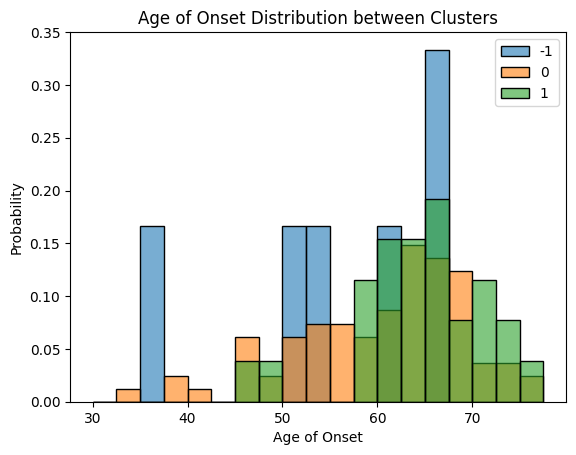

In [70]:
plot_hist(cl_data, feature_name='Age of Onset', bins=np.arange(30, 80, 2.5))

C-1: Mean Disease duration = 31.86 [23.84]
C0: Mean Disease duration = 60.08 [48.79]
C1: Mean Disease duration = 61.23 [45.34]


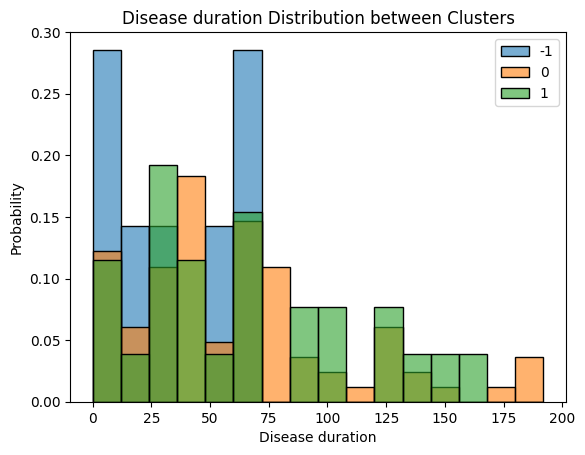

In [71]:
plot_hist(cl_data, feature_name='Disease duration', bins=np.arange(0, 200, 12))

C-1: Mean UPDRS part III = 24.14 [9.89]
C0: Mean UPDRS part III = 22.89 [12.42]
C1: Mean UPDRS part III = 30.65 [11.81]


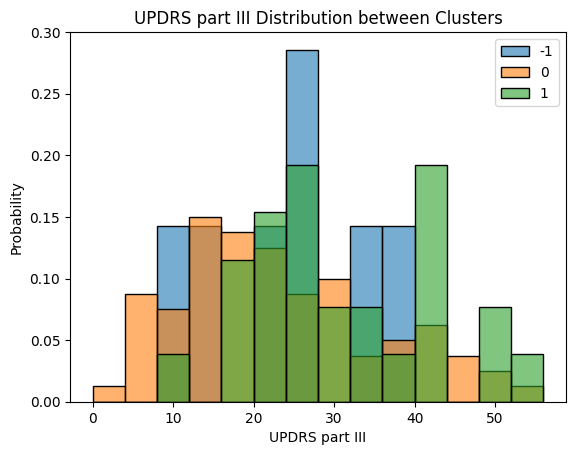

In [72]:
plot_hist(cl_data, feature_name='UPDRS part III', bins=np.arange(0, 60, 4))

C-1: Mean UPDRS Total = 39.86 [22.65]
C0: Mean UPDRS Total = 38.21 [20.37]
C1: Mean UPDRS Total = 46.65 [20.01]


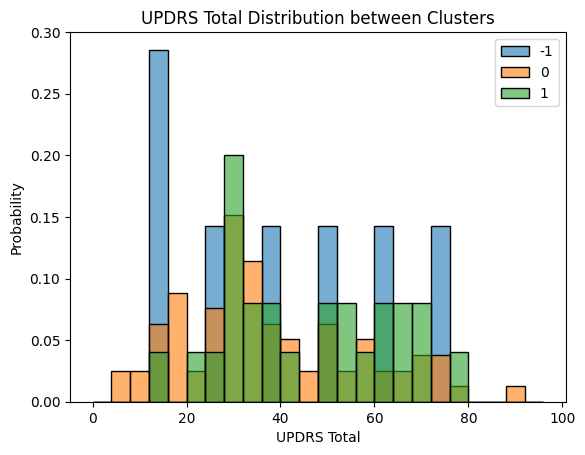

In [73]:
plot_hist(cl_data, feature_name='UPDRS Total', bins=np.arange(0, 100, 4))

C-1: Mean MoCA = 26.57 [2.82]
C0: Mean MoCA = 25.46 [2.88]
C1: Mean MoCA = 23.85 [3.63]


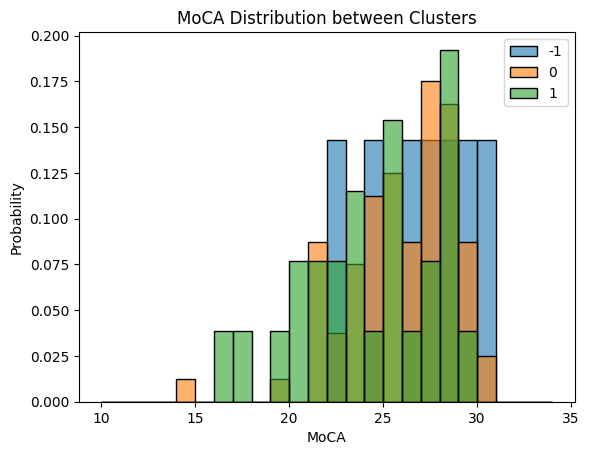

In [74]:
plot_hist(cl_data, feature_name='MoCA', bins=np.arange(10, 35, 1))

C-1: Mean CTT1 = 52.51 [16.59]
C0: Mean CTT1 = 59.33 [30.15]
C1: Mean CTT1 = 90.56 [46.53]


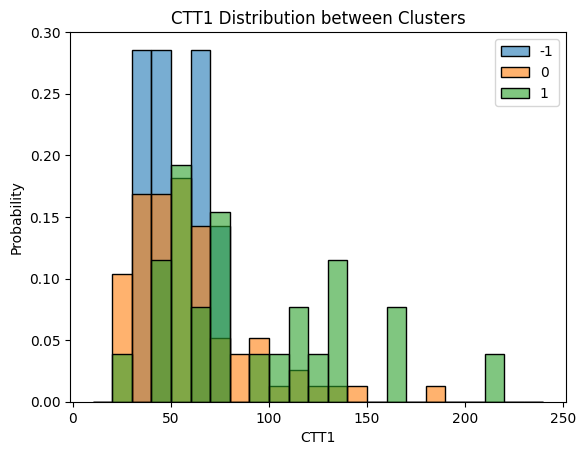

In [75]:
plot_hist(cl_data, feature_name='CTT1', bins=np.arange(10, 250, 10))

C-1: Mean CTT2 = 106.48 [41.94]
C0: Mean CTT2 = 104.23 [40.83]
C1: Mean CTT2 = 158.36 [72.33]


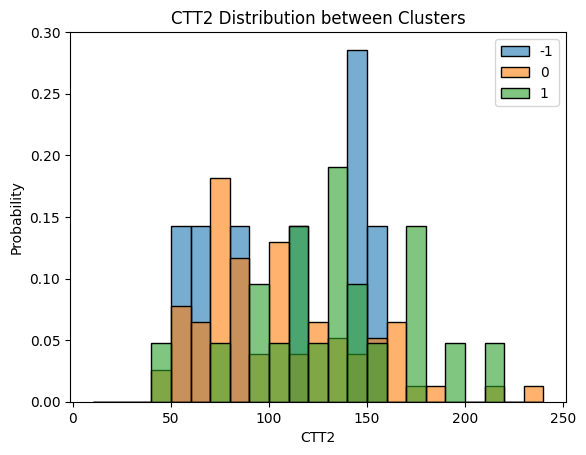

In [76]:
plot_hist(cl_data, feature_name='CTT2', bins=np.arange(10, 250, 10))

C-1: Mean Gait speed usual = 1.13 [0.23]
C0: Mean Gait speed usual = 1.04 [0.2]
C1: Mean Gait speed usual = 1.06 [0.19]


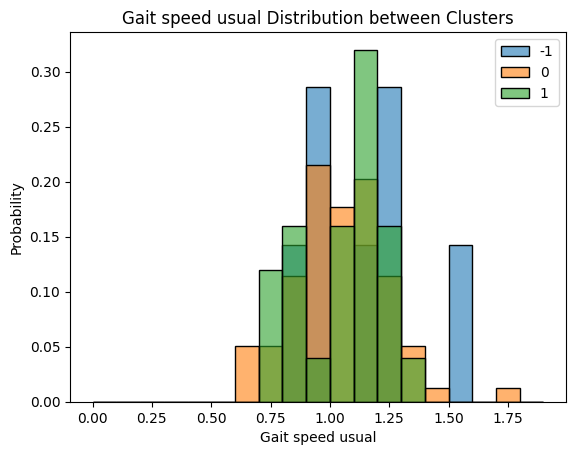

In [77]:
plot_hist(cl_data, feature_name='Gait speed usual', bins=np.arange(0, 2, 0.1))

C-1: Mean Gait speed DT = 0.95 [0.31]
C0: Mean Gait speed DT = 0.87 [0.22]
C1: Mean Gait speed DT = 0.89 [0.2]


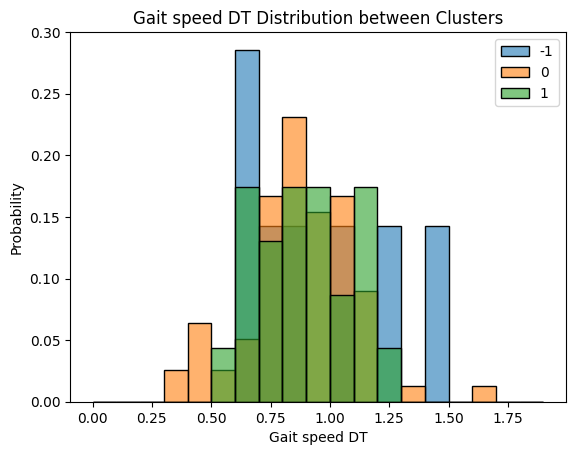

In [78]:
plot_hist(cl_data, feature_name='Gait speed DT', bins=np.arange(0, 2, 0.1))

C-1: Mean LEDD = 267.0 [242.0]
C0: Mean LEDD = 442.79 [397.4]
C1: Mean LEDD = 393.08 [372.01]


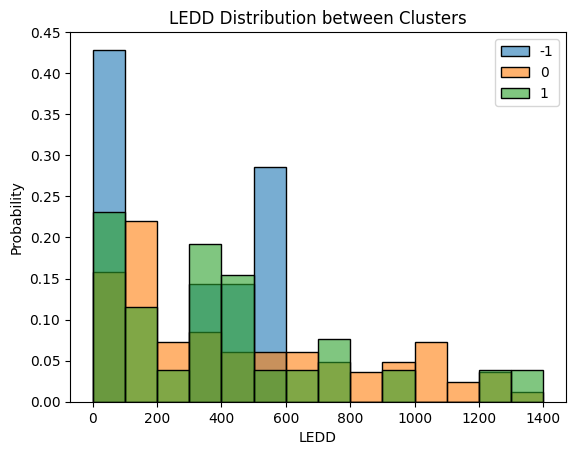

In [79]:
plot_hist(cl_data, feature_name='LEDD', bins=np.arange(0, 1500, 100))

### Further Neurophysiological Assessment

In [104]:
pd_colors = sns.color_palette("viridis", 3)   # 3 shades of orange
hc_color = "gray"

palette = {
    -1: pd_colors[0],
    0: pd_colors[1],
    1: pd_colors[2],
    "HC": hc_color
}

#### Relative Band Power

In [105]:
melted = clustered_features.melt(
    id_vars=['Condition', 'clusterID', 'Subject', 'Electrode'],
    var_name='FeatureName',
    value_name='RawValue'
)
relatives = ['theta_relative_bandpower', 'alpha_relative_bandpower', 'beta_relative_bandpower', 'gamma_relative_bandpower']
melted["FeatureName"] = pd.Categorical(melted["FeatureName"], categories=relatives, ordered=True)
melted["clusterID"] = pd.Categorical(melted["clusterID"], categories=['HC', 0, 1], ordered=True)


In [106]:
agg_powers = melted.loc[melted['FeatureName'].isin(relatives)].groupby(['Condition', 'clusterID', 'Subject', 'FeatureName'])[['RawValue']].mean().reset_index()

<Axes: xlabel='FeatureName', ylabel='clusterID'>

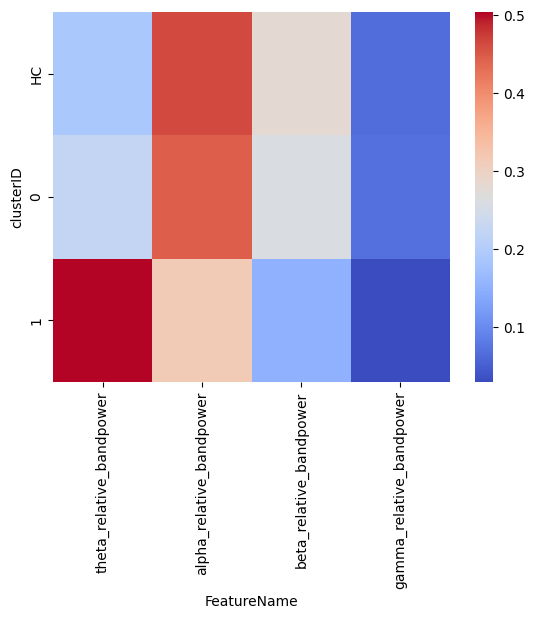

In [107]:
sns.heatmap(    agg_powers.loc[(agg_powers['Condition'] == 'sit')].pivot_table(
        index='clusterID', values='RawValue', columns='FeatureName'
    ), cmap='coolwarm')

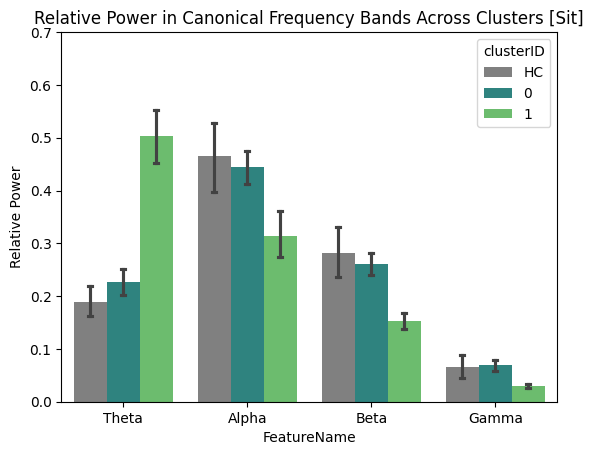

In [132]:
ax = sns.barplot(
    agg_powers.loc[(agg_powers['Condition'] == 'sit')],
    x='FeatureName', y='RawValue', hue='clusterID', palette=palette, capsize=.1
)

ax.set_xticklabels(["Theta", "Alpha", "Beta", "Gamma"])
plt.title('Relative Power in Canonical Frequency Bands Across Clusters [Sit]')
plt.ylabel('Relative Power')
plt.ylim(0, 0.7)
plt.show()

<Axes: xlabel='FeatureName', ylabel='clusterID'>

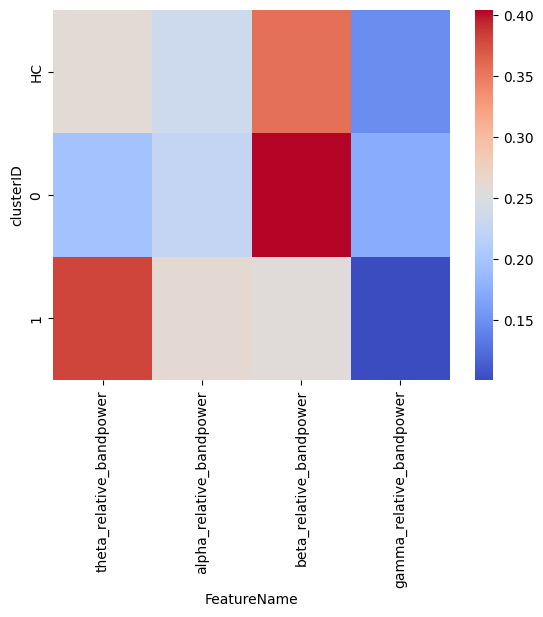

In [109]:
sns.heatmap(    agg_powers.loc[(agg_powers['Condition'] == 'walk')].pivot_table(
        index='clusterID', values='RawValue', columns='FeatureName'
    ), cmap='coolwarm')

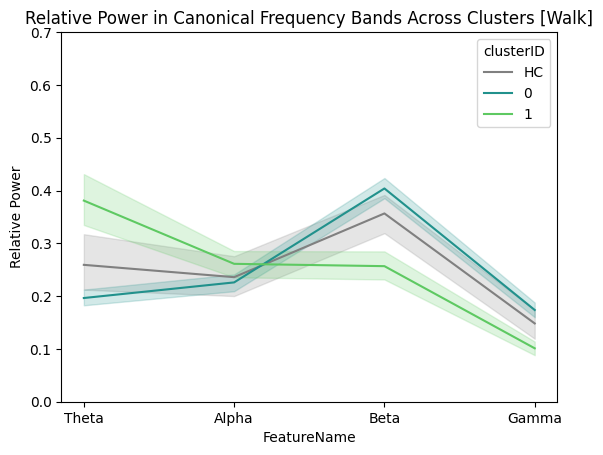

In [110]:
ax = sns.lineplot(
    agg_powers.loc[(agg_powers['Condition'] == 'walk')],
    x='FeatureName', y='RawValue', hue='clusterID', palette=palette
)

ax.set_xticklabels(["Theta", "Alpha", "Beta", "Gamma"])
plt.title('Relative Power in Canonical Frequency Bands Across Clusters [Walk]')
plt.ylabel('Relative Power')
plt.ylim(0, 0.7)
plt.show()

#### Alpha \ Theta Ratio

In [111]:
transposed = melted.loc[melted['FeatureName'].isin(['alpha_relative_bandpower', 'theta_relative_bandpower'])].pivot_table(
    index=['Condition', 'clusterID', 'Subject', 'Electrode'],
    columns='FeatureName',
    values='RawValue'
).reset_index()

transposed['alpha_theta_ratio'] = transposed['alpha_relative_bandpower'] / transposed['theta_relative_bandpower']

In [112]:
ratios = transposed.groupby(['Subject', 'clusterID', 'Condition'])[['alpha_theta_ratio']].mean().reset_index()

In [113]:
anova(ratios.loc[ratios['Condition'] == 'sit'], 'alpha_theta_ratio')

F = 15.400, p = 0.0002


In [114]:
anova(ratios.loc[ratios['Condition'] == 'walk'], 'alpha_theta_ratio')

F = 18.916, p = 0.0000


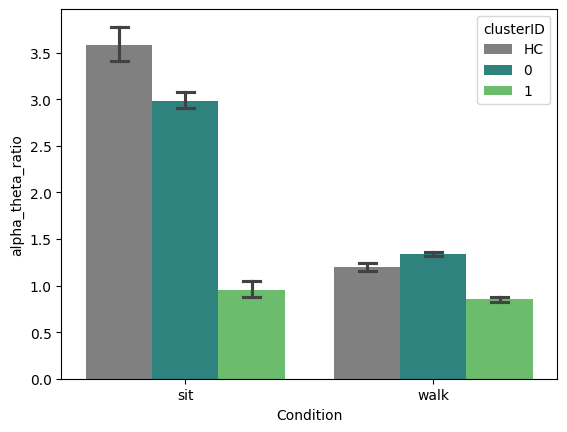

In [131]:
ax = sns.barplot(
    transposed,
    x='Condition', y='alpha_theta_ratio', hue='clusterID', capsize=.2, palette=palette
)

C-1: Mean Alpha Theta Ratio = nan [nan]
C0: Mean Alpha Theta Ratio = 1.34 [0.69]
C1: Mean Alpha Theta Ratio = 0.85 [0.51]


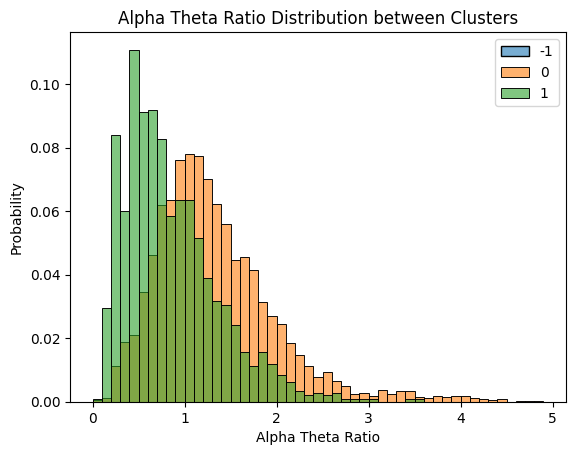

In [116]:
transposed['Alpha Theta Ratio'] = transposed['alpha_theta_ratio']
plot_hist(transposed.loc[transposed['Condition'] == 'walk'], feature_name='Alpha Theta Ratio', bins=np.arange(0, 5, 0.1))

C-1: Mean Alpha Theta Ratio = nan [nan]
C0: Mean Alpha Theta Ratio = 2.98 [3.09]
C1: Mean Alpha Theta Ratio = 0.95 [1.71]


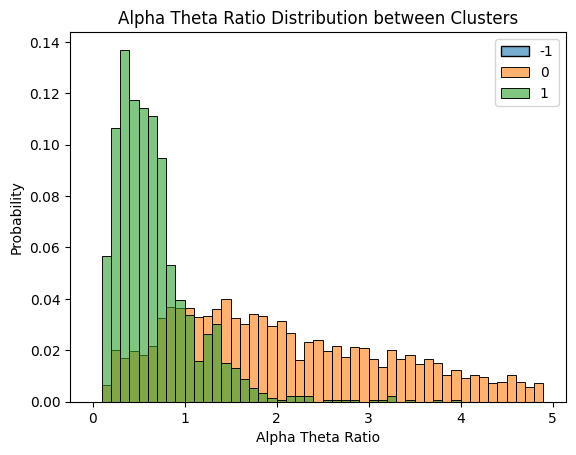

In [117]:
plot_hist(transposed.loc[transposed['Condition'] == 'sit'], feature_name='Alpha Theta Ratio', bins=np.arange(0, 5, 0.1))

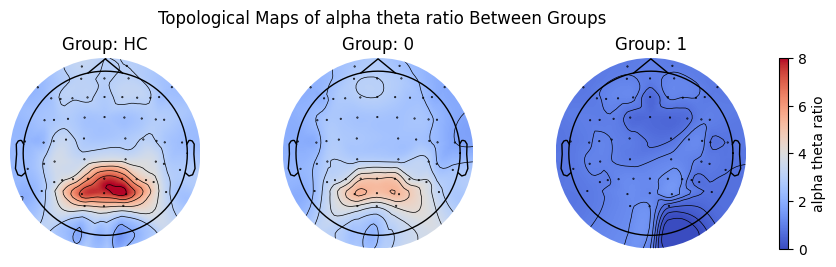

In [118]:
sit_plot = TopoPlot(
    data=transposed.loc[transposed['Condition'] == 'sit'], 
    group_col='clusterID', 
    channel_col='Electrode', 
    feature_names=['alpha_theta_ratio'],
    dims=(WIDTH, HEIGHT),
    cmap='coolwarm',
    vlim=(0, 8))

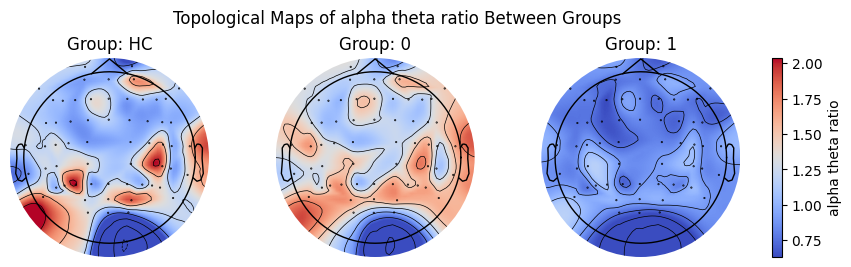

In [119]:
sit_plot = TopoPlot(
    data=transposed.loc[transposed['Condition'] == 'walk'], 
    group_col='clusterID', 
    channel_col='Electrode', 
    feature_names=['alpha_theta_ratio'],
    dims=(WIDTH, HEIGHT),
    cmap='coolwarm')

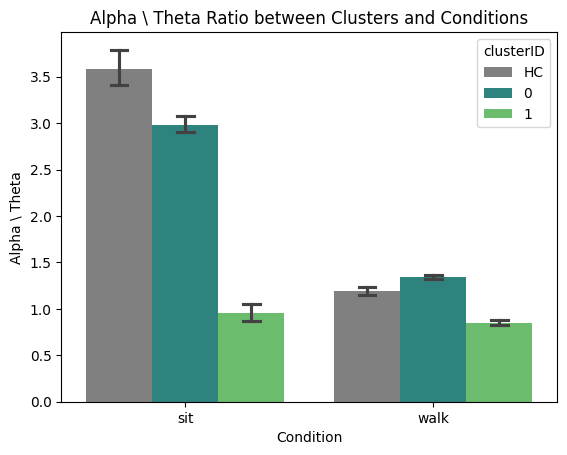

In [120]:
ax = sns.barplot(
    transposed,
    x='Condition', y='alpha_theta_ratio', hue='clusterID', capsize=.2, palette=palette)

plt.title('Alpha \ Theta Ratio between Clusters and Conditions')
plt.ylabel('Alpha \ Theta')
plt.show()

#### Temporal Complexity

In [121]:
complexities = clustered_features.groupby(['clusterID', 'Subject', 'Condition'])[['LZC_mean', 'PermEn_mean']].mean().reset_index()

In [122]:
anova(complexities.loc[complexities['Condition'] == 'sit'], 'LZC_mean')

F = 48.424, p = 0.0000


In [123]:
anova(complexities.loc[complexities['Condition'] == 'walk'], 'LZC_mean')

F = 32.935, p = 0.0000


In [124]:
clustered_features.groupby(['Condition', 'clusterID'])['LZC_mean'].mean()

Condition  clusterID
sit        -1.0         0.385330
            0.0         0.421746
            1.0         0.355922
            HC          0.413853
walk       -1.0         0.440641
            0.0         0.474340
            1.0         0.396721
            HC          0.443300
Name: LZC_mean, dtype: float64

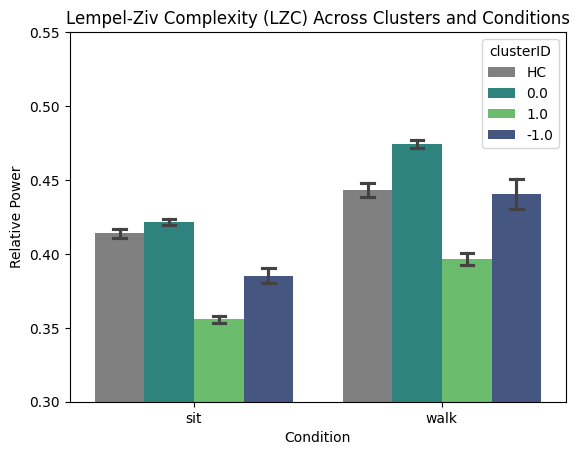

In [125]:
ax = sns.barplot(
    clustered_features,
    x='Condition', y='LZC_mean', hue='clusterID', capsize=.2, palette=palette
)


plt.ylim(.3, .55)
plt.title('Lempel-Ziv Complexity (LZC) Across Clusters and Conditions')
plt.ylabel('Relative Power')
plt.show()

In [126]:
anova(complexities.loc[complexities['Condition'] == 'sit'], 'PermEn_mean')

F = 16.925, p = 0.0001


In [127]:
anova(complexities.loc[complexities['Condition'] == 'walk'], 'PermEn_mean')

F = 37.425, p = 0.0000


In [128]:
clustered_features.groupby(['Condition', 'clusterID'])['PermEn_mean'].mean()

Condition  clusterID
sit        -1.0         0.889716
            0.0         0.944005
            1.0         0.912586
            HC          0.935097
walk       -1.0         0.973723
            0.0         1.003087
            1.0         0.979127
            HC          0.988767
Name: PermEn_mean, dtype: float64

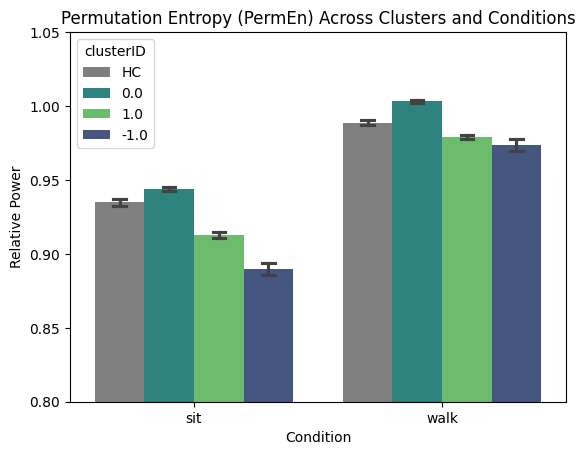

In [129]:
ax = sns.barplot(
    clustered_features,
    x='Condition', y='PermEn_mean', hue='clusterID', capsize=.2, palette=palette
)

plt.ylim(0.8, 1.05)
plt.title("Permutation Entropy (PermEn) Across Clusters and Conditions")
plt.ylabel('Relative Power')
plt.show()